## HW8：人工智能与机器学习（ddl：12.28）
你的名字：

你的学号：


注意：
1. 请使用 Python 语言完成所有编程作业。
2. 允许并鼓励同学间合作，但严禁抄袭别人的代码，且严禁直接复制粘贴由人工智能生成的代码。
3. 请直接在题干后附加代码块和必要的公式，讨论等。
4. 作图请包含 X,Y 轴的标签，以及必要的图例。过多信息的缺失可能会导致丢分。

作业只需要在这个 jupyter notebook 里添加代码，并直接提交修改后的 jupyter notebook，文件请重命名为`姓名-学号-作业x`。

另外请在作业最后**简要说明本次作业完成情况**，以及大致心路历程；另外标注**致谢**，借助了**哪位同学或 ChatGPT 等工具**的帮助，如果自己独立完成的，只需标注"独立完成"。如果上述备注有缺失，会导致作业扣分！

<font color='red'>**本次作业请只用`numpy`库来完成模型的搭建**</font>

### **霍普菲尔德网络与受限玻尔兹曼机**

2024年诺贝尔物理学奖授予给了John J.Hopfield和Geoffrey E.Hinton，以表彰他们“为利用人工神经网络进行机器学习做出的基础性发现和发明”。他们利用统计物理概念设计出的人工神经网络，奠定了现代人工智能（AI）的核心基础，推动了深度学习和模式识别等技术的发展。 

本次作业中，你需要借助numpy库亲自搭建并运用二人分别提出的两个关键神经网络模型及其衍生——霍普菲尔德（Hopfield）网络和受限玻尔兹曼机（BM）。

#### **1 Hopfield网络** 

考虑一个长度为N的一维点阵，每个格点上有一个神经元（自旋） $x_i \in \{+1, -1\}$。系统的能量由哈密顿量给出（不含外场）：

$$E(\mathbf{x}) = - \sum_{\langle i,j \rangle} w_{ij} x_i x_j$$

其中权重$w_{ij}$对应于自旋玻璃模型中的耦合强度$J_{ij}$，与伊辛模型不同，自旋玻璃模型中的系数$J_{ij}$通常并不一致。在Hopfield网络中，对于我们想要同时的p种记忆：$x_i=\xi^{(\mu)}_i$（$\mu=0,1,...,p-1$），可以基于赫布规则（Hebb's rule）将权重取为：
$$ w_{ij} = \frac{1}{N} \sum_{\mu=0}^{p-1} \xi_i^{(\mu)} \xi_j^{(\mu)},\quad w_{ii}=0 $$

从特定初态出发寻找体系基态的演化过程，参照讲义上提到的蒙卡方法（随机异步动力学）即可，请确保步数不低于1000。

为考察网络的记忆能力，我们可以将神经元的初态设为某一待考察的记忆，将其演化至基态后，可以通过下式定义的重叠度（Overlap）来考察对该记忆的回忆率：
$$m^{(\mu)} = \frac{1}{N} \sum_{i=1}^N x_i \xi_i^{(\mu)}$$

若$m^{(\mu)}\ge 0.95$，即可被视为对记忆$\mu$实现了完美回忆；有多个记忆的网络对于全部模式都能正确回忆时，代表该网络能够承载这一数量的记忆。

**(a)** 取$N=100$，且设$\xi^{(\mu)}$为各元素在$\{-1,1\}$上等概率分布的随机向量。
* 将$p$从1取到20，分别执行100次按上文方法构建的Hopfield网络的基态计算（生成随机记忆$\xi^{(\mu)}$的过程也需要重复），求出并记录每一个p取值下网络能承载全部p个记忆的频率$P_n$。
* 作出$P_n$随$p$的变化折线图。
* Amit, Gutfreund 和 Sompolinsky三人于1987年通过理论推导得出，尺寸为$N$的Hopfield网络所能容纳的记忆数大致为$0.14N$。如果将判断网络能够承载的条件定为$P_n>0.5$，你画出的折线是否符合这一结论？

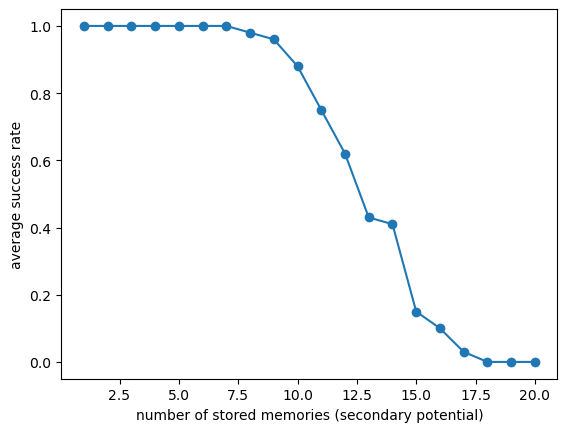

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def generate_mem(N, p):
    mem = np.zeros((N, p), dtype=int)
    for i in range(N):
        for j in range(p):
            if np.random.randint(2) == 0:
                mem[i, j] = -1
            else:
                mem[i, j] = 1
    return mem


def weight_init(mem):
    N, p = mem.shape
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                for mu in range(p):
                    W[i, j] += mem[i, mu] * mem[j, mu]
                W[i, j] /= N
    return W


def evacuate(W, state, steps):
    N = len(state)
    for i in range(steps):
        index = np.random.randint(N)
        wx = W[index, :] @ state
        if wx >= 0:
            state[index] = 1
        else:
            state[index] = -1
    return state


N = 100

plist = list(range(1, 21))
success_rates = []
for p in plist:
    success_count = 0
    for trial in range(100):
        mem = generate_mem(N, p)
        W = weight_init(mem)
        fail = False
        for mu in range(p):
            init_state = mem[:, mu].copy()
            final_state = evacuate(W, init_state, 1500)
            m = mem[:, mu] @ final_state / N
            if m <= 0.95:
                fail = True
                break
        if not fail:
            success_count += 1
    success_rates.append(success_count / 100)

plt.plot(plist, success_rates, marker='o')
plt.xlabel('number of stored memories (secondary potential)')
plt.ylabel('average success rate')
plt.show()

结果确实符合记忆数约等于0.14N，本题100个节点得到的记忆大约有13个。

**(b)** Hopfield网络的记忆能力也会受到能量形式的影响，将上面的能量改为指数形式：
$$E(\mathbf{x}) = -\sum_{\mu} \exp{(\sum_i\xi^{(\mu)}_i x_i)}$$

本问中，我们分别取$N=4,8,12$作三次训练，演化步数不低于$50N$步即可，其余条件与 **(a)** 问一致。在同一张图中画出这三条$P_n-p$变化曲线，请根据你的观察猜测此时的网络最大记忆容纳数是如何随N变化的。（事实上，能量函数改为指数型的Hopfield网络与当下得到广泛应用的Transformer架构有十分紧密的联系）

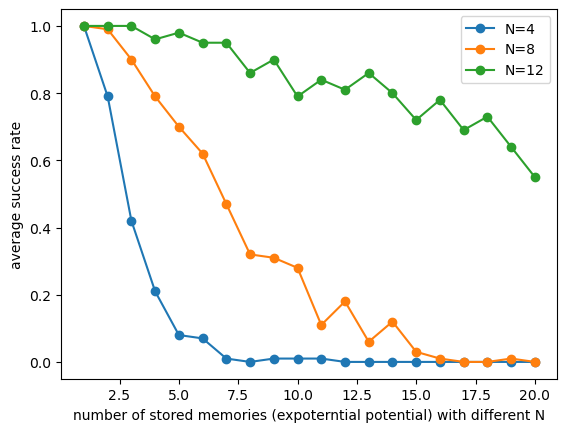

In [2]:
def evacuate_exp(mem, state, steps):
    N, p = mem.shape
    for i in range(steps):
        index = np.random.randint(N)
        E_old = 0
        for j in range(p):
            E_old += -np.exp(mem[:, j] @ state)
        state[index] *= -1
        E_new = 0
        for j in range(p):
            E_new += -np.exp(mem[:, j] @ state)
        if E_new > E_old:
            state[index] *= -1
    return state


N = [4, 8, 12]

for n in N:
    plist = list(range(1, 21))
    success_rates = []
    for p in plist:
        success_count = 0
        for trial in range(100):
            mem = generate_mem(n, p)
            fail = False
            for mu in range(p):
                init_state = mem[:, mu].copy()
                final_state = evacuate_exp(mem, init_state, 60 * n)
                m = mem[:, mu] @ final_state / n
                if m <= 0.95:
                    fail = True
                    break
            if not fail:
                success_count += 1
        success_rates.append(success_count / 100)
    plt.plot(plist, success_rates, marker='o', label=f'N={n}')
plt.legend()
plt.xlabel('number of stored memories (expoterntial potential) with different N')
plt.ylabel('average success rate')
plt.show()

本问中网络的记忆容量得到了极大改善，看起来容量增长速度大于N，可能是$e^{cN}$。

#### **2 受限玻尔兹曼机** 
基于Hopfield网络，将其拓展成两层后即得玻尔兹曼机（BM），再施加限制，取消层间相互作用，就能给出可用二分图表示的受限玻尔兹曼机。这里选用的能量函数为：

$$ E(v, h) = a^T v - b^T h-v^T W h=-\sum_i a_iv_i -\sum_j b_jh_j-\sum_{ij} v_i W_{ij} h_j$$

$v,h$分别为可见层与隐藏层向量，$W$是权重矩阵，$a,b$是两层的偏置向量，一般RBM神经元的取值范围为$\{0,1\}$。网络传递方式有很多选择，这里我们考虑伯努利采样：

$$\textbf{前向传播（编码）：}P(h=1|v) = \sigma (W^T v + b) $$
$$\textbf{反向传播（重构）：}P(v=1|h)=\sigma (W h + a)$$

其中$\sigma(x)=\frac{1}{1+e^{-x}}$是sigmoid函数，此处由玻尔兹曼因子的比值得出，传播时以这些概率P来判定是否将待更新的各神经元设为1，否则设为0。

训练RBM时，**一次对比散度**（CD-1）法是最常用的方法之一，通过把将网络对数据集的对数似然函数$\ln{P(v)}$ **最大化**（注意参数更新的方向）为目标，可以求得其对权重矩阵和偏置向量的梯度：

$$ \frac{\partial \ln P(v)}{\partial w_{ij}} = \langle v_i h_j \rangle^{(0)} - \langle v_i h_j \rangle^{(1)} $$

$$ \frac{\partial \ln P(v)}{\partial a_{i}} = \langle v_i \rangle^{(0)} - \langle v_i \rangle^{(1)} $$

$$ \frac{\partial \ln P(v)}{\partial b_{j}} = \langle h_j \rangle^{(0)} - \langle h_j \rangle^{(1)} $$

每次计算梯度时，你都需要从把输入数据传入可见层开始在网络中来回传递两次：$v\rightarrow h\rightarrow v\rightarrow h $，其中第一次的$v,h$对应于上标$(0)$，第二次的$v,h$对应于上标$(1)$；括号“<>”表示系综平均，对于训练过程而言，只需采用随机梯度下降（SGD）的思路，逐代（epoch）训练即可。

还需要提及的一点是，为了减小噪声、提高收敛效率，实际计算对权重矩阵的梯度时一般用隐藏层的期望值，亦即采样概率来代替隐藏层$h$（基于[Rao–Blackwell定理](https://en.wikipedia.org/wiki/Rao%E2%80%93Blackwell_theorem)）：

$$ \frac{\partial \ln P(v)}{\partial w_{ij}} =  v_i^{(0)}\cdot P(h_j^{(0)}=1|v_j^{(0)})  - v_i^{(1)}\cdot P(h_j^{(1)}=1|v_j^{(1)}) $$

隐藏层偏置$b$的梯度计算同理。相对地，由于我们认为可见层$v$应该直接对应于真实情况，故不会被期望值取代。

完成训练后的RBM可以通过将输入数据传到可见层，于网络内来回传播若干次，将其演化为与训练数据接近的状态，与Hopfield网络有一定的相似性。

下面你将用它来完成一个简单的图像识别任务。

**(c)数字识别** 我们给出10个5x3的二维矩阵，分别为0-9十个数字的图案（丐版MNIST数据集），以及五个测试图案：

In [3]:
import numpy as np
# 要是觉得这个代码块太长，可以考虑隐藏单元格（jupyterlab与vscode等notebook编辑工具中都可以通过点击左侧蓝条来完成）
numbers=[]
zero=np.array([[1,1,1],
               [1,0,1],
               [1,0,1],
               [1,0,1],
               [1,1,1]])
one=np.array([[0,1,0],
              [1,1,0],
              [0,1,0],
              [0,1,0],
              [1,1,1]])
two=np.array([[1,1,1],
              [0,0,1],
              [1,1,1],
              [1,0,0],
              [1,1,1]])
three=np.array([[1,1,1],
                [0,0,1],
                [1,1,1],
                [0,0,1],
                [1,1,1]])
four=np.array([[1,0,1],
               [1,0,1],
               [1,1,1],
               [0,0,1],
               [0,0,1]])
five=np.array([[1,1,1],
              [1,0,0],
              [1,1,1],
              [0,0,1],
              [1,1,1]])
six=np.array([[1,1,1],
              [1,0,0],
              [1,1,1],
              [1,0,1],
              [1,1,1]])
seven=np.array([[1,1,1],
                [0,0,1],
                [0,1,0],
                [1,0,0],
                [1,0,0]])
eight=np.array([[1,1,1],
                [1,0,1],
                [1,1,1],
                [1,0,1],
                [1,1,1]])
nine=np.array([[1,1,1],
               [1,0,1],
               [1,1,1],
               [0,0,1],
               [1,1,1]])
numbers.append(zero)
numbers.append(one)
numbers.append(two)
numbers.append(three)
numbers.append(four)
numbers.append(five)
numbers.append(six)
numbers.append(seven)
numbers.append(eight)
numbers.append(nine)

# 0,1,4,6,8的测试图案，与原数字稍微有点不同
test_numbers=[]
test_zero=np.array([[0,1,1],
                    [1,0,1],
                    [1,0,1],
                    [1,0,1],
                    [1,1,1]])
test_one= np.array([[0,1,0],
                    [1,1,0],
                    [0,1,0],
                    [0,1,0],
                    [1,1,0]])
test_four=np.array([[1,0,1],
                    [1,0,1],
                    [0,1,0],
                    [0,0,1],
                    [0,0,1]])
test_six=np.array([[1,1,1],
                   [1,0,0],
                   [1,1,1],
                   [1,0,1],
                   [1,1,0]])
test_eight=np.array([[1,1,1],
                     [1,0,1],
                     [1,1,1],
                     [1,0,1],
                     [0,1,1]])


test_numbers.append(test_zero)
test_numbers.append(test_one)
test_numbers.append(test_four)
test_numbers.append(test_six)
test_numbers.append(test_eight)


1. 搭建一个可见层长度$N_v=15$，隐藏层长度$N_h=30$的受限玻尔兹曼机，通过上文介绍的过程对`numbers`中的十个数字图案进行训练，要求与提示：
    * 使用`np.random.randn`随机设置权重矩阵$W$的初值，$a,b$初始取为0向量即可
    * 训练迭代数（epoch）取为2000，SGD学习率设为0.1
    * 训练或还原数据时，使用`flatten()`方法将数字图案拉成一维数组；使用`reshape((5,3))`方法将一维数组还原为二维图案
2. 通过将`test_numbers`输入可见层，输出来回传播三次后的可见层来测试训练完成的RBM，且对每个测试图案都用`print`输出两个用5x3二维数组表示的结果：输出图案（矩阵元只有0或1）与期望（输出图案中各元素取为1的概率）。你的RBM能否很好地将各测试数字还原？

In [4]:
import numpy as np

np.set_printoptions(formatter={'float_kind': '{:<4.2f}'.format})  # 确保输出的numpy数组能美观地靠左对齐，直接在此后编写代码即可

Nv = 15
Nh = 30

W = np.random.randn(Nv, Nh)
a = np.zeros(Nv)
b = np.zeros(Nh)
learning_rate = 0.1

epochs = 2000

sigma = lambda x: 1 / (1 + np.exp(-x))
for epoch in range(epochs):
    for num in numbers:
        v0 = np.ndarray.flatten(num)
        h0 = sigma(W.T @ v0 + b)
        v1_prob = sigma(W @ h0 + a)
        v1 = np.zeros(Nv)
        for i in range(Nv):
            if np.random.rand() < v1_prob[i]:
                v1[i] = 1
        h1 = sigma(W.T @ v1 + b)
        W += learning_rate * (np.outer(v0, h0) - np.outer(v1, h1))
        a += learning_rate * (v0 - v1)
        b += learning_rate * (h0 - h1)
for test_num in test_numbers:
    v0 = np.ndarray.flatten(test_num)
    h0 = sigma(W.T @ v0 + b)
    v1_prob = sigma(W @ h0 + a)
    v1 = np.zeros(Nv)
    for i in range(Nv):
        if np.random.rand() < v1_prob[i]:
            v1[i] = 1
    h1 = sigma(W.T @ v1 + b)
    v2_prob = sigma(W @ h1 + a)
    v2 = np.zeros(Nv)
    for i in range(Nv):
        if np.random.rand() < v2_prob[i]:
            v2[i] = 1
    h2 = sigma(W.T @ v2 + b)
    v3_prob = sigma(W @ h2 + a)
    v3 = np.zeros(Nv)
    for i in range(Nv):
        if np.random.rand() < v3_prob[i]:
            v3[i] = 1
    print("for number:")
    print(test_num)
    print("reconstructed result:")
    print(v3.reshape((5, 3)))
    print("each element == 1 has property:")
    print(v3_prob.reshape((5, 3)))

for number:
[[0 1 1]
 [1 0 1]
 [1 0 1]
 [1 0 1]
 [1 1 1]]
reconstructed result:
[[1.00 1.00 1.00]
 [1.00 0.00 1.00]
 [1.00 0.00 1.00]
 [1.00 0.00 1.00]
 [1.00 1.00 1.00]]
each element == 1 has property:
[[1.00 1.00 1.00]
 [1.00 0.00 1.00]
 [1.00 0.01 1.00]
 [1.00 0.00 1.00]
 [1.00 1.00 1.00]]
for number:
[[0 1 0]
 [1 1 0]
 [0 1 0]
 [0 1 0]
 [1 1 0]]
reconstructed result:
[[0.00 1.00 0.00]
 [1.00 1.00 0.00]
 [0.00 1.00 0.00]
 [0.00 1.00 0.00]
 [1.00 1.00 1.00]]
each element == 1 has property:
[[0.00 1.00 0.00]
 [1.00 1.00 0.00]
 [0.00 1.00 0.00]
 [0.00 1.00 0.00]
 [1.00 1.00 1.00]]
for number:
[[1 0 1]
 [1 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]]
reconstructed result:
[[1.00 0.00 1.00]
 [1.00 0.00 1.00]
 [1.00 1.00 1.00]
 [0.00 0.00 1.00]
 [0.00 0.00 1.00]]
each element == 1 has property:
[[1.00 0.00 1.00]
 [1.00 0.00 1.00]
 [1.00 1.00 1.00]
 [0.00 0.00 1.00]
 [0.00 0.00 1.00]]
for number:
[[1 1 1]
 [1 0 0]
 [1 1 1]
 [1 0 1]
 [1 1 0]]
reconstructed result:
[[1.00 1.00 1.00]
 [1.00 0.00 0.00]
 [

对于特征比较明显的几个数字，如1和4，网络重建效果较好，但是对于几个比较相似的数字，如6，8，9，网络就很容易弄混。

**(d)** 你认为Hopfield网络（换能量函数之前）与RBM中哪个在模式识别问题上能获得更广泛的应用？它与另一个模型相比优势主要从何而来？

感觉还是RBM能在模式识别问题上有更广泛的应用。Hopfield网络没有隐藏层，只能通过显式特征来进行学习；但是RBM存在隐藏层，可以通过隐藏层实现更复杂的相互作用学习和特征提取。

### 作业完成情况：

本次作业耗时3小时，主要在研究具体计算如何进行，这部分借助了ChatGPT的帮助。感觉Hopfield网络在换了能量函数后计算效率下降不少，算一次得花好长时间，可能有的计算结果有一点涨落。